Applying LSTM on AirPaseengers data. Data analysis can be found in Timeseries ARIMA notebook.  

In [2]:
import warnings; 
warnings.simplefilter('ignore')

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
import math

In [4]:
import tensorflow as tf

In [5]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, Flatten,ConvLSTM2D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping

In [6]:
df = pd.read_csv('AirPassengers.csv',usecols = [1])
df.head(3)

,#Passengers
0,112
1,118
2,132


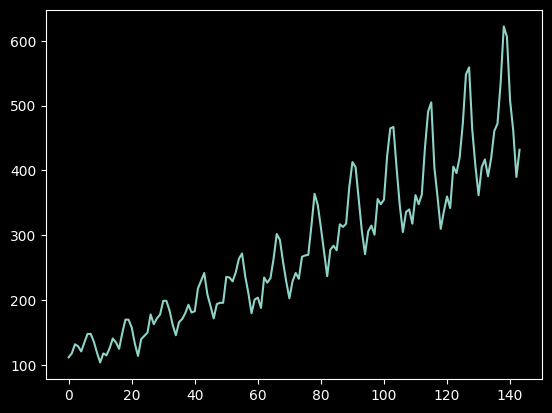

In [7]:
plt.plot(df)

In [8]:
#Convert pandas dataframe to numpy array
dataset = df.values
dataset = dataset.astype('float32') #Convert values to float

In [9]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

In [10]:
#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 60% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [11]:
# We cannot fit the model like we normally do for image processing where we have
#X and Y. We need to transform our data into something that looks like X and Y values.
# This way it can be trained on a sequence rather than indvidual datapoints. 
# Let us convert into n number of columns for X where we feed sequence of numbers
#then the final column as Y where we provide the next number in the sequence as output.
# So let us convert an array of values into a dataset matrix

#seq_size is the number of previous time steps to use as 
#input variables to predict the next time period.

#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) 
#and Y is the number of passengers at the next time (t + 1).

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

In [12]:
seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

In [13]:
print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))


Shape of training set: (84, 10)
Shape of test set: (38, 10)


In [14]:
print(trainY.shape)
print(testY.shape)


(84,)
(38,)


In [15]:
testY

array([0.46911195, 0.38803086, 0.44787642, 0.45559844, 0.4131274 ,
       0.4980695 , 0.47104248, 0.49999997, 0.6389961 , 0.7471043 ,
       0.7741313 , 0.57915056, 0.492278  , 0.3976834 , 0.44980696,
       0.49420848, 0.45945945, 0.5830116 , 0.5637065 , 0.61003864,
       0.71042466, 0.8571429 , 0.8783784 , 0.69305015, 0.5849421 ,
       0.4980695 , 0.58108103, 0.6042471 , 0.554054  , 0.60810804,
       0.6891892 , 0.71042466, 0.8320464 , 1.        , 0.96911204,
       0.7799227 , 0.6891892 , 0.55212355], dtype=float32)

In [16]:
# Reshape input to be [samples, time steps, features]. LSTM expects the i/p to be that way
trainX1 = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX1 = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [17]:
print(trainX.shape)
print(trainX.shape[0])
print(trainX.shape[1])
print(trainX.shape[0], 1, trainX.shape[1])
print(testX.shape[0], 1, testX.shape[1])

(84, 10)
84
10
84 1 10
38 1 10


### Model Training 

#### 1) Single LSTM Layer

In [19]:
print('Single LSTM with hidden Dense...')
model = Sequential()
model.add(LSTM(64, input_shape=(None, seq_size)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', restore_best_weights=True)
model.summary()

Single LSTM with hidden Dense...




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                19200     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21313 (83.25 KB)
Trainable params: 21313 (83.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
trainX1.shape,trainY.shape,testX1.shape,testY.shape

((84, 1, 10), (84,), (38, 1, 10), (38,))

In [21]:
model.fit(trainX1, trainY, validation_data=(testX1, testY),
          verbose=2, epochs=100)

Epoch 1/100

3/3 - 3s - loss: 0.0603 - val_loss: 0.2597 - 3s/epoch - 938ms/step
Epoch 2/100
3/3 - 0s - loss: 0.0362 - val_loss: 0.1606 - 48ms/epoch - 16ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0190 - val_loss: 0.0890 - 53ms/epoch - 18ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0098 - val_loss: 0.0444 - 49ms/epoch - 16ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0069 - val_loss: 0.0247 - 44ms/epoch - 15ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0083 - val_loss: 0.0205 - 51ms/epoch - 17ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0100 - val_loss: 0.0202 - 52ms/epoch - 17ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0095 - val_loss: 0.0204 - 54ms/epoch - 18ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0078 - val_loss: 0.0230 - 44ms/epoch - 15ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0065 - val_loss: 0.0286 - 45ms/epoch - 15ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0059 - val_loss: 0.0337 - 47ms/epoch - 16ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0060 - val_loss: 0.0357 - 48ms/epoch - 16ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0060 

In [22]:
# make predictions

trainPredict = model.predict(trainX1)
testPredict = model.predict(testX1)


2/2 [==============================] - 0s 5ms/step


In [23]:
# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [32]:
trainY[0].shape,trainY[0]

((84,),
 array([103.99999952, 117.99999916, 115.00000199, 125.99999674,
        140.99999801, 135.00000368, 125.00000283, 148.9999956 ,
        169.99999891, 169.99999891, 157.99999481, 133.00000042,
        114.00000036, 139.99999638, 145.00000452, 149.99999723,
        177.9999965 , 163.00000295, 172.00000217, 177.9999965 ,
        198.99999982, 198.99999982, 184.00000627, 162.00000133,
        146.00000615, 165.9999924 , 171.00000054, 179.99999976,
        193.00000549, 181.00000139, 183.00000464, 217.99999988,
        230.00000398, 241.99999264, 209.00000066, 191.00000223,
        172.00000217, 194.00000712, 195.99999493, 195.99999493,
        235.99999831, 234.99999668, 229.00000235, 242.99999427,
        263.99999759, 272.00001061, 236.99999994, 211.00000392,
        179.99999976, 201.00000308, 203.99999252, 187.99999735,
        234.99999668, 226.9999991 , 233.99999506, 263.99999759,
        301.99999771, 292.99999849, 259.00000488, 229.00000235,
        203.00000633, 229.000002

In [37]:
trainPredict.shape,trainPredict

((84, 1),
 array([[122.50436 ],
        [116.43927 ],
        [133.11293 ],
        [132.14328 ],
        [133.08748 ],
        [145.40808 ],
        [148.42172 ],
        [144.13712 ],
        [152.57162 ],
        [159.84296 ],
        [158.16342 ],
        [152.99536 ],
        [130.27426 ],
        [124.383255],
        [149.94028 ],
        [153.44113 ],
        [149.92497 ],
        [171.85983 ],
        [173.05112 ],
        [181.38344 ],
        [182.07773 ],
        [182.66338 ],
        [177.51443 ],
        [177.2509  ],
        [158.78699 ],
        [151.70035 ],
        [178.24432 ],
        [179.28513 ],
        [186.35297 ],
        [192.93932 ],
        [195.238   ],
        [198.68805 ],
        [216.10645 ],
        [217.04788 ],
        [218.1459  ],
        [201.30817 ],
        [184.11957 ],
        [179.12541 ],
        [203.16238 ],
        [201.07605 ],
        [198.62233 ],
        [233.31818 ],
        [244.55869 ],
        [249.92282 ],
        [241.76947 ],


In [33]:
trainPredict[:,0].shape,trainPredict[:,0]

((84,),
 array([122.50436 , 116.43927 , 133.11293 , 132.14328 , 133.08748 ,
        145.40808 , 148.42172 , 144.13712 , 152.57162 , 159.84296 ,
        158.16342 , 152.99536 , 130.27426 , 124.383255, 149.94028 ,
        153.44113 , 149.92497 , 171.85983 , 173.05112 , 181.38344 ,
        182.07773 , 182.66338 , 177.51443 , 177.2509  , 158.78699 ,
        151.70035 , 178.24432 , 179.28513 , 186.35297 , 192.93932 ,
        195.238   , 198.68805 , 216.10645 , 217.04788 , 218.1459  ,
        201.30817 , 184.11957 , 179.12541 , 203.16238 , 201.07605 ,
        198.62233 , 233.31818 , 244.55869 , 249.92282 , 241.76947 ,
        245.35645 , 247.68544 , 234.79025 , 204.64807 , 182.39389 ,
        220.23653 , 228.69748 , 212.6248  , 240.32993 , 251.58078 ,
        265.15784 , 269.61127 , 281.71832 , 267.16168 , 251.007   ,
        216.83763 , 193.92226 , 240.3934  , 249.36076 , 240.97557 ,
        270.3391  , 294.83344 , 298.26956 , 314.5337  , 334.35187 ,
        314.34592 , 294.2433  , 257.2122

In [24]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 19.29 RMSE
Test Score: 40.60 RMSE


In [66]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

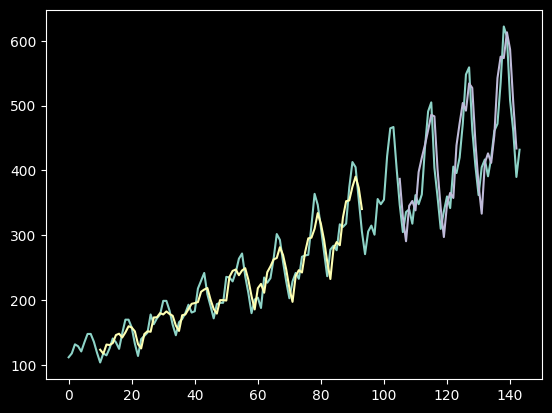

In [67]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

#### 2) Stacked LSTM with 1 hidden layer

In [71]:
# reshape input to be [samples, time steps, features]
trainX2 = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX2 = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(None, seq_size)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, None, 50)          12200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 32)                1632      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 34065 (133.07 KB)
Trainable params: 34065 (133.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [91]:
trainX2.shape, testX2.shape ,trainY.shape,testY.shape

((84, 1, 10), (38, 1, 10), (1, 84), (1, 38))

In [72]:
model.fit(trainX2, trainY, validation_data=(testX2, testY),
          verbose=2, epochs=100)

Epoch 1/100
3/3 - 3s - loss: 0.0616 - val_loss: 0.3319 - 3s/epoch - 935ms/step
Epoch 2/100
3/3 - 0s - loss: 0.0482 - val_loss: 0.2850 - 50ms/epoch - 17ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0360 - val_loss: 0.2393 - 48ms/epoch - 16ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0265 - val_loss: 0.1955 - 49ms/epoch - 16ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0196 - val_loss: 0.1548 - 44ms/epoch - 15ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0146 - val_loss: 0.1199 - 44ms/epoch - 15ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0134 - val_loss: 0.0918 - 46ms/epoch - 15ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0139 - val_loss: 0.0730 - 46ms/epoch - 15ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0148 - val_loss: 0.0641 - 47ms/epoch - 16ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0148 - val_loss: 0.0636 - 53ms/epoch - 18ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0140 - val_loss: 0.0677 - 54ms/epoch - 18ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0128 - val_loss: 0.0733 - 46ms/epoch - 15ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0120 -

In [73]:
# make predictions

trainPredict = model.predict(trainX2)
testPredict = model.predict(testX2)


2/2 [==============================] - 0s 3ms/step


In [74]:
# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [1]:
trainY

NameError: name 'trainY' is not defined

In [75]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 21.61 RMSE
Test Score: 60.29 RMSE


In [76]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

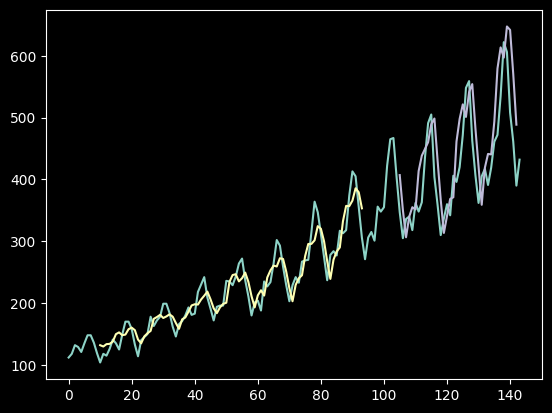

In [77]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

#### 3) Bidirectional LSTM

In [ ]:
# reshape input to be [samples, time steps, features]
trainX3 = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX3 = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [101]:
#For some sequence forecasting problems we may need LSTM to learn
#sequence in both forward and backward directions
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(None,trainX3.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 100)               24400     
 onal)                                                           
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 24501 (95.71 KB)
Trainable params: 24501 (95.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [95]:
trainX3.shape,testX3.shape ,np.array(trainY).shape,np.array(testY).shape

((84, 1, 10), (38, 1, 10), (1, 84), (1, 38))

In [98]:
trainY_reshaped = np.reshape(trainY, (trainY.shape[1], trainY.shape[0], 1))
testY_reshaped = np.reshape(testY, (testY.shape[1], testY.shape[0], 1))
trainY_reshaped.shape,testY_reshaped.shape

((84, 1, 1), (38, 1, 1))

In [102]:
model.fit(trainX3,trainY_reshaped, validation_data=(testX3,testY_reshaped),
          verbose=2, epochs=100)

Epoch 1/100
3/3 - 4s - loss: 54042.5898 - val_loss: 183439.8750 - 4s/epoch - 1s/step
Epoch 2/100
3/3 - 0s - loss: 54032.6680 - val_loss: 183401.6875 - 63ms/epoch - 21ms/step
Epoch 3/100
3/3 - 0s - loss: 54023.3398 - val_loss: 183362.7188 - 53ms/epoch - 18ms/step
Epoch 4/100
3/3 - 0s - loss: 54013.2930 - val_loss: 183323.1250 - 72ms/epoch - 24ms/step
Epoch 5/100
3/3 - 0s - loss: 54003.9414 - val_loss: 183281.8906 - 57ms/epoch - 19ms/step
Epoch 6/100
3/3 - 0s - loss: 53993.5703 - val_loss: 183239.3125 - 65ms/epoch - 22ms/step
Epoch 7/100
3/3 - 0s - loss: 53982.9922 - val_loss: 183194.7969 - 93ms/epoch - 31ms/step
Epoch 8/100
3/3 - 0s - loss: 53972.3633 - val_loss: 183147.5625 - 76ms/epoch - 25ms/step
Epoch 9/100
3/3 - 0s - loss: 53961.6133 - val_loss: 183096.7344 - 64ms/epoch - 21ms/step
Epoch 10/100
3/3 - 0s - loss: 53949.5000 - val_loss: 183042.7031 - 55ms/epoch - 18ms/step
Epoch 11/100
3/3 - 0s - loss: 53936.7266 - val_loss: 182985.1094 - 60ms/epoch - 20ms/step
Epoch 12/100
3/3 - 0s -

In [104]:
# make predictions

trainPredict = model.predict(trainX3)
testPredict = model.predict(testX3)

2/2 [==============================] - 0s 9ms/step


In [107]:
# Inverse transform predictions
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1, 1)).flatten()
testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1)).flatten()

# Inverse transform actual values
trainY = scaler.inverse_transform(trainY_reshaped.reshape(-1, 1)).flatten()
testY = scaler.inverse_transform(testY_reshaped.reshape(-1, 1)).flatten()


In [109]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 3701881209.74 RMSE
Test Score: 185450.21 RMSE


In [111]:
trainY[0]

53976.00076560863

In [113]:
trainPredict[:,0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

#### 4) Conv LSTM

In [84]:

#The layer expects input as a sequence of two-dimensional images, 
#therefore the shape of input data must be: [samples, timesteps, rows, columns, features]

trainX4 = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
testX4 = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 64)          19200     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 21313 (83.25 KB)
Trainable params: 21313 (83.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [85]:
model.fit(trainX4, trainY, validation_data=(testX4, testY),
          verbose=2, epochs=100)

ValueError: Data cardinality is ambiguous:
  x sizes: 84
  y sizes: 1
Make sure all arrays contain the same number of samples.